In [20]:
import torch
import torch.nn as nn

import math
import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class StockTrade(object):
    def __init__(self, data_set, start_date, start_balance, window, horizon):
        self.data_set = data_set
        self.start_date = start_date
        self.start_balance = start_balance
        self.window = window
        self.horizon = horizon
        self.data_list = self.get_data()
        
        # We define the action space
        self.action_space = {'buy': 1, 'hold': 0, 'sell': -1}
        self.action_names = ['buy', 'hold', 'sell']

        # We define other useful variables
        self.balance = None  # track the agent's account balance in one episode
        self.action = None  # track the agent's action
        self.t = 0  # track the current time step in one episode

    def get_data(self):
        data_list = []
        with open('data/' + self.data_set + '.csv', 'r') as file:
            lines = file.read().splitlines()
        for line in lines[1:]:
            data_list.append(float(line.split(",")[1]))
        return data_list

    def get_state(self, t):
        # t is the time stamp in the data_list
        if t - self.window >= -1:
            prices = self.data_list[(t-self.window+1): (t+1)]
        else: 
            prices = (-(t-self.window+1)*[self.data_list[0]]) + self.data_list[0: (t+1)]
        scaled_state = []
        for i in range(0, self.window - 1):
            scaled_state.append(1 / (1 + math.exp(prices[i]-prices[i+1])))
        return np.array([scaled_state])

    def reset(self):
        # We reset the agent's start date to a random valid trading day
        start_date = np.random.choice(range(self.window-1, len(self.data_list)-self.horizon), 1)[0]
        self.start_date = start_date
        # We reset the agent's balance to the start balance
        self.balance = self.start_balance
        # We reset the timeout tracker to be 0
        self.t = 0
        # We reset the agent's state
        state = self.get_state(self.start_date + self.t)
        # We set the information
        info = {}
        return state, info

    def step(self, action):
        '''
        Args:
            action (string): all feasible values are ['buy', 'hold', 'sell']
        '''
        # Get agent's current balance
        current_balance = self.balance
        # Convert the action name to operation
        act_arr = self.action_space[action]
        # Get today's and next day's stock open price
        time_stamp = self.start_date + self.t
        price_today = self.data_list[time_stamp]
        price_next_day = self.data_list[time_stamp+1]
        # Compute the reward
        reward = (price_next_day-price_today) * act_arr
        self.balance += reward
        # Check the termination
        if self.t == self.horizon - 1 or self.balance < 0:
            terminated = True
        else:
            terminated = False
        # Update the agent's next state, action and time step trackers
        next_state = self.get_state(time_stamp+1)
        self.action = action
        self.t += 1
        return next_state, reward, terminated, False, {}

def test():
    my_env = StockTrade("train_set", 200, 10, 50, 200)
    state, _ = my_env.reset()
    for i in range(1000):
        action = np.random.choice(list(my_env.action_space.keys()), 1)[0]
        next_state, reward, done, _, _ = my_env.step(action)
        #if i % 100 == 0:
            #print(next_state)
        #print(reward)
        #print(my_env.balance)
        if done:
            state, _ = my_env.reset()
            print("done!")
        else:
            state = next_state

In [3]:
def customized_weights_init(m):
    '''
    Customized uniform weight initialization
    '''
    # compute the gain
    gain = nn.init.calculate_gain('relu')
    # init the convolutional layer
    if isinstance(m, nn.Conv2d):
        # init the params using uniform
        nn.init.xavier_uniform_(m.weight, gain=gain)
        nn.init.constant_(m.bias, 0)
    # init the linear layer
    if isinstance(m, nn.Linear):
        # init the params using uniform
        nn.init.xavier_uniform_(m.weight, gain=gain)
        nn.init.constant_(m.bias, 0)

class DeepQNet(nn.Module):
    def __init__(self, input_dim, num_hidden_layer, dim_hidden_layer, output_dim):
        super(DeepQNet, self).__init__()
        
        # define the input dimension
        self.input_dim = input_dim
        # define the number of the hidden layers
        self.hidden_num = num_hidden_layer
        # define the hidden dimension
        self.hidden_dim = dim_hidden_layer
        # define the output dimension
        self.output_dim = output_dim

        # define the input linear layer here
        self.input = nn.Linear(self.input_dim, self.hidden_dim)
        # define the activation function after the input layer
        self.fc0 = nn.ReLU()
        # define the first hidden layer here
        self.hl0 = nn.Linear(self.hidden_dim, self.hidden_dim)
        # define the activation function after the first hidden layer
        self.fc1 = nn.ReLU()
        # define the second hidden layer here
        self.hl1 = nn.Linear(self.hidden_dim, self.hidden_dim)
        # define the activation function after the second hidden layer
        self.fc2 = nn.ReLU()
        # define the output layer here
        self.output = nn.Linear(self.hidden_dim, self.output_dim)        

    def forward(self, x):
        '''
        Implement the forward propagation
        '''
        # forward x through the input layer
        x = self.input(x)
        # apply activation
        x = self.fc0(x)
        # forward x throught the first hidden layer
        x = self.hl0(x)
        # apply activation
        x = self.fc1(x)
        # forward x throught the second hidden layer
        x = self.hl1(x)
        # apply activation
        x = self.fc2(x)
        # forward x throught the output layer
        y = self.output(x)
        return y

class ReplayBuffer(object):
    '''
    Implement the Replay Buffer as a class, which contains:
        - self._data_buffer (list): a list variable to store all transition tuples
        - add: a function to add new transition tuple into the buffer
        - sample_batch: a function to sample a batch training data from the buffer
    '''
    def __init__(self, buffer_size):
        '''
        Args:
            buffer_size (int): size of the replay buffer
        '''
        # total size of the replay buffer
        self.total_size = buffer_size
        # create a list to store the transitions
        self._data_buffer = []
        self._next_idx = 0

    def __len__(self):
        return len(self._data_buffer)

    def add(self, obs, act, reward, next_obs, done):
        # create a tuple
        trans = (obs, act, reward, next_obs, done)
        # add the tuple to update the replay buffer
        if self._next_idx >= len(self._data_buffer):
            self._data_buffer.append(trans)
        else:
            self._data_buffer[self._next_idx] = trans
        # calculate the next index
        self._next_idx = (self._next_idx + 1) % self.total_size

    def _encode_sample(self, indices):
        '''
        Function to fetch the state, action, reward, next state, and done arrays
        Args:
            indices (list): list contains the index of all sampled transition tuples
        '''
        # lists for transitions
        obs_list, actions_list, rewards_list, next_obs_list, dones_list = [], [], [], [], []
        # collect the data
        for idx in indices:
            # get the single transition
            data = self._data_buffer[idx]
            obs, act, reward, next_obs, d = data
            # store to the list
            obs_list.append(np.array(obs, copy=False))
            actions_list.append(np.array(act, copy=False))
            rewards_list.append(np.array(reward, copy=False))
            next_obs_list.append(np.array(next_obs, copy=False))
            dones_list.append(np.array(d, copy=False))
        # return the sampled batch data as numpy arrays
        return (np.array(obs_list), np.array(actions_list), np.array(rewards_list),
                np.array(next_obs_list), np.array(dones_list))

    def sample_batch(self, batch_size):
        '''
        Args:
            batch_size (int): size of the sampled batch data.
        '''
        # sample indices with replaced
        indices = [np.random.randint(0, len(self._data_buffer)) for _ in range(batch_size)]
        return self._encode_sample(indices)

class LinearSchedule(object):
    '''
    Customized decay epsilon values
    '''
    def __init__(self, start_value, end_value, duration):
        # start value
        self._start_value = start_value
        # end value
        self._end_value = end_value
        # time steps that value changes from the start value to the end value
        self._duration = duration
        # difference between the start value and the end value
        self._schedule_amount = end_value - start_value

    def get_value(self, time):
        '''
        Get decay epsilon values
        '''
        # if time > duration, use the end value, else use the scheduled value
        if time > self._duration:
            return self._end_value
        else:
            return ((time/self._duration)*self._schedule_amount) + self._start_value

In [4]:
class DQNAgent(object):
    def __init__(self, params):
        # save the parameters
        self.params = params
        # environment parameters
        self.action_dim = params['action_dim']
        self.obs_dim = params['observation_dim']
        # executable actions
        self.action_space = params['action_space']

        # create value network
        self.behavior_policy_net = DeepQNet(input_dim=params['observation_dim'],
                                            num_hidden_layer=params['hidden_layer_num'],
                                            dim_hidden_layer=params['hidden_layer_dim'],
                                            output_dim=params['action_dim'])
        # create target network
        self.target_policy_net = DeepQNet(input_dim=params['observation_dim'],
                                          num_hidden_layer=params['hidden_layer_num'],
                                          dim_hidden_layer=params['hidden_layer_dim'],
                                          output_dim=params['action_dim'])

        # initialize target network with behavior network
        self.behavior_policy_net.apply(customized_weights_init)
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())

        # send the agent to a specific device: cpu or gpu
        self.device = torch.device("cpu")
        self.behavior_policy_net.to(self.device)
        self.target_policy_net.to(self.device)

        # optimizer
        self.optimizer = torch.optim.Adam(self.behavior_policy_net.parameters(),
                                          lr=params['learning_rate'])
        
    def get_action(self, obs, eps):
        if np.random.random() < eps:  
            action = np.random.choice(self.action_space, 1)[0]
            return action
        else:  
            obs = self._arr_to_tensor(obs).view(1, -1)
            with torch.no_grad():
                q_values = self.behavior_policy_net(obs)
                action = q_values.max(dim=1)[1].item()
            return self.action_space[int(action)]

    def update_behavior_policy(self, batch_data):
        # convert batch data to tensor and put them on device
        batch_data_tensor = self._batch_to_tensor(batch_data)

        # get the transition data
        obs_tensor = batch_data_tensor['obs']
        actions_tensor = batch_data_tensor['action']
        next_obs_tensor = batch_data_tensor['next_obs']
        rewards_tensor = batch_data_tensor['reward']
        dones_tensor = batch_data_tensor['done']
        actions_tensor = actions_tensor.reshape(actions_tensor.shape[0],1,1)

        # compute the q value estimation using the behavior network
        predicted_targets = self.behavior_policy_net(obs_tensor).gather(2, actions_tensor)
        # compute the TD target using the target network
        with torch.no_grad():
            labels_next = self.behavior_policy_net(next_obs_tensor).max(1)[0].unsqueeze(1)
        labels = rewards_tensor + (self.params['gamma']* labels_next*(1-dones_tensor))
        # compute the loss
        td_loss = nn.MSELoss()(predicted_targets, labels).to(self.device)
        # minimize the loss
        self.optimizer.zero_grad()
        td_loss.backward()
        self.optimizer.step()
        return td_loss.item()

    def update_target_policy(self):
        '''
        Copy the behavior policy network to the target network
        '''
        # hard update
        self.target_policy_net.load_state_dict(self.behavior_policy_net.state_dict())

    # auxiliary functions
    def _arr_to_tensor(self, arr):
        arr = np.array(arr)
        arr_tensor = torch.from_numpy(arr).float().to(self.device)
        return arr_tensor

    def _batch_to_tensor(self, batch_data):
        # store the tensor
        batch_data_tensor = {'obs': [], 'action': [], 'reward': [], 'next_obs': [], 'done': []}
        # get the numpy arrays
        obs_arr, action_arr, reward_arr, next_obs_arr, done_arr = batch_data
        # convert to tensors
        batch_data_tensor['obs'] = torch.tensor(obs_arr, dtype=torch.float32).to(self.device)
        batch_data_tensor['action'] = torch.tensor(action_arr).long().view(-1, 1).to(self.device)
        batch_data_tensor['reward'] = torch.tensor(reward_arr, dtype=torch.float32).view(-1, 1).to(self.device)
        batch_data_tensor['next_obs'] = torch.tensor(next_obs_arr, dtype=torch.float32).to(self.device)
        batch_data_tensor['done'] = torch.tensor(done_arr, dtype=torch.float32).view(-1, 1).to(self.device)
        return batch_data_tensor

In [5]:
def train_dqn_agent(env, params):
    my_agent = DQNAgent(params)
    # create the epsilon-greedy schedule
    my_schedule = LinearSchedule(start_value=params['epsilon_start_value'],
                                 end_value=params['epsilon_end_value'],
                                 duration=params['epsilon_duration'])
    # create the replay buffer
    replay_buffer = ReplayBuffer(params['replay_buffer_size'])

    # initialize training variables
    rewards = []
    train_returns = []
    train_loss = []
    loss = 0

    # reset the environment
    obs, _ = env.reset()

    # start training
    pbar = tqdm.trange(params['total_training_time_step'])
    last_best_return = 0
    for t in pbar:
        # scheduled epsilon at time step t
        eps_t = my_schedule.get_value(t)
        # get one epsilon-greedy action
        action = my_agent.get_action(obs, eps_t)
        # step in the environment
        next_obs, reward, done, _, _ = env.step(action)
        # add to the buffer
        replay_buffer.add(obs, env.action_names.index(action), reward, next_obs, done)
        rewards.append(reward)

        # check termination
        if done:
            # compute the return
            G = 0
            for r in reversed(rewards):
                G = r + params['gamma'] * G
            if G > last_best_return:
                torch.save(my_agent.behavior_policy_net.state_dict(), f"./{params['model_name']}")
            # store the return
            train_returns.append(G)
            episode_idx = len(train_returns)
            # print the information
            pbar.set_description(
                f"Ep={episode_idx} | "
                f"Len={len(rewards)} | "
                f"G={np.mean(train_returns[-10:]) if train_returns else 0:.2f} | "
                f"Eps={eps_t}"
            )
            # reset the environment
            rewards = []
            obs, _ = env.reset()
        else:
            # increment
            obs = next_obs
            
        if t > params['start_training_step']:
            # update the behavior model
            if not np.mod(t, params['freq_update_behavior_policy']):
                # update the behavior policy network
                loss = my_agent.update_behavior_policy(replay_buffer.sample_batch(my_agent.params['batch_size']))
                train_loss.append(loss)  
            # update the target model
            if not np.mod(t, params['freq_update_target_policy']):
                # update the target policy network
                my_agent.update_target_policy()    
    # save the results
    return train_returns, train_loss, my_agent

def test_dqn_agent(my_agent, testing_steps = 500, gamma = 0.99):
    test_returns = []
    rewards = []
    i = 0
    env = StockTrade("test_set", 50, 5000, 50, 200)
    obs, _ = env.reset()
    while i < testing_steps:
        eps_t = 0
        action = my_agent.get_action(obs, eps_t)
        next_obs, reward, done, _, _ = env.step(action)
        rewards.append(reward)
        if done:
            # compute the discounted return
            G = 0
            for r in reversed(rewards):
                G = r + gamma * G
            test_returns.append(G)
            # reset the environment
            rewards = []
            obs, _ = env.reset()
            i += 1
        else:
            # increment
            obs = next_obs
    return test_returns

def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Time Steps")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()

if __name__ == '__main__':
    # set the random seed
    np.random.seed(1234)
    torch.manual_seed(1234)

    # create environment
    my_env = StockTrade("train_set", 50, 5000, 50, 200)

    # create training parameters
    train_parameters = {
        'observation_dim': 49,
        'action_dim': 3,
        'action_space': my_env.action_names,
        'hidden_layer_num': 2,
        'hidden_layer_dim': 128,
        'gamma': 0.99,

        'total_training_time_step': 500_000,

        'epsilon_start_value': 1.0,
        'epsilon_end_value': 0.01,
        'epsilon_duration': 250_000,

        'replay_buffer_size': 50000,
        'start_training_step': 2000,
        'freq_update_behavior_policy': 4,
        'freq_update_target_policy': 2000,

        'batch_size': 32,
        'learning_rate': 1e-3,

        'model_name': "stock_trade.pt"
    }

    # create experiment
    train_returns, train_loss, my_agent = train_dqn_agent(my_env, train_parameters)
    test_returns = test_dqn_agent(my_agent, testing_steps=500)

Ep=10 | Len=200 | G=3.41 | Eps=0.99208396:   0%|                              | 1400/500000 [00:00<00:35, 13898.42it/s]C:\ProgramData\Anaconda3\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([32, 32, 3])) that is different to the input size (torch.Size([32, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Ep=2500 | Len=200 | G=142.87 | Eps=0.01: 100%|████████████████████████████████| 500000/500000 [10:58<00:00, 759.80it/s]


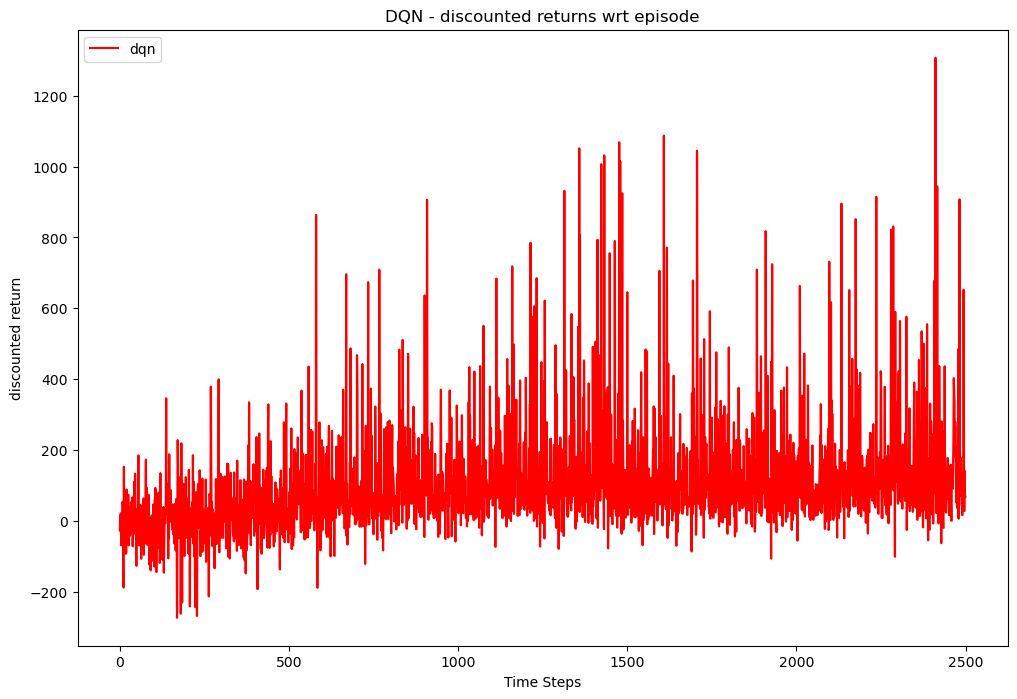

In [7]:
plot_curves([np.array([train_returns])], ['dqn'], ['r'], 'discounted return', 'DQN - discounted returns wrt episode')

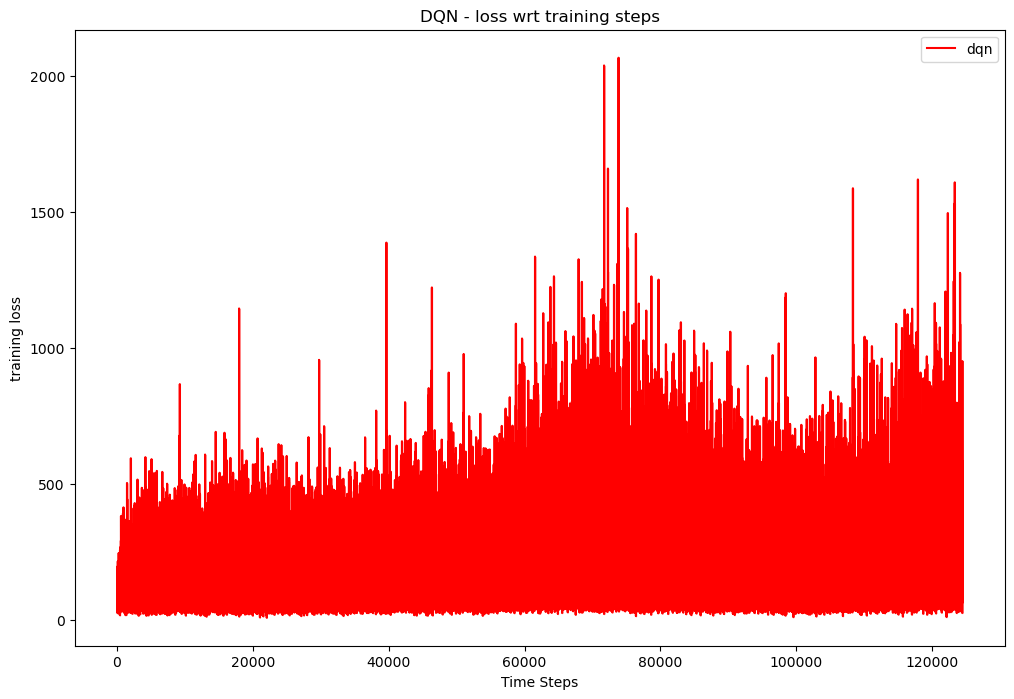

In [8]:
plot_curves([np.array([train_loss])], ['dqn'], ['r'], 'training loss', 'DQN - loss wrt training steps')

In [19]:
def test_dqn_agent(my_agent, data_set, testing_steps = 500, gamma = 0.99):
    test_returns = []
    rewards = []
    i = 0
    env = StockTrade(data_set, 50, 5000, 50, 200)
    obs, _ = env.reset()
    while i < testing_steps:
        eps_t = 0
        action = my_agent.get_action(obs, eps_t)
        next_obs, reward, done, _, _ = env.step(action)
        rewards.append(reward)
        if done:
            # compute the discounted return
            G = 0
            for r in reversed(rewards):
                G = r + gamma * G
            test_returns.append(G)
            # reset the environment
            rewards = []
            obs, _ = env.reset()
            i += 1
        else:
            # increment
            obs = next_obs
    return test_returns

train_returns = test_dqn_agent(my_agent, "train_set")
test_returns = test_dqn_agent(my_agent, "test_set")

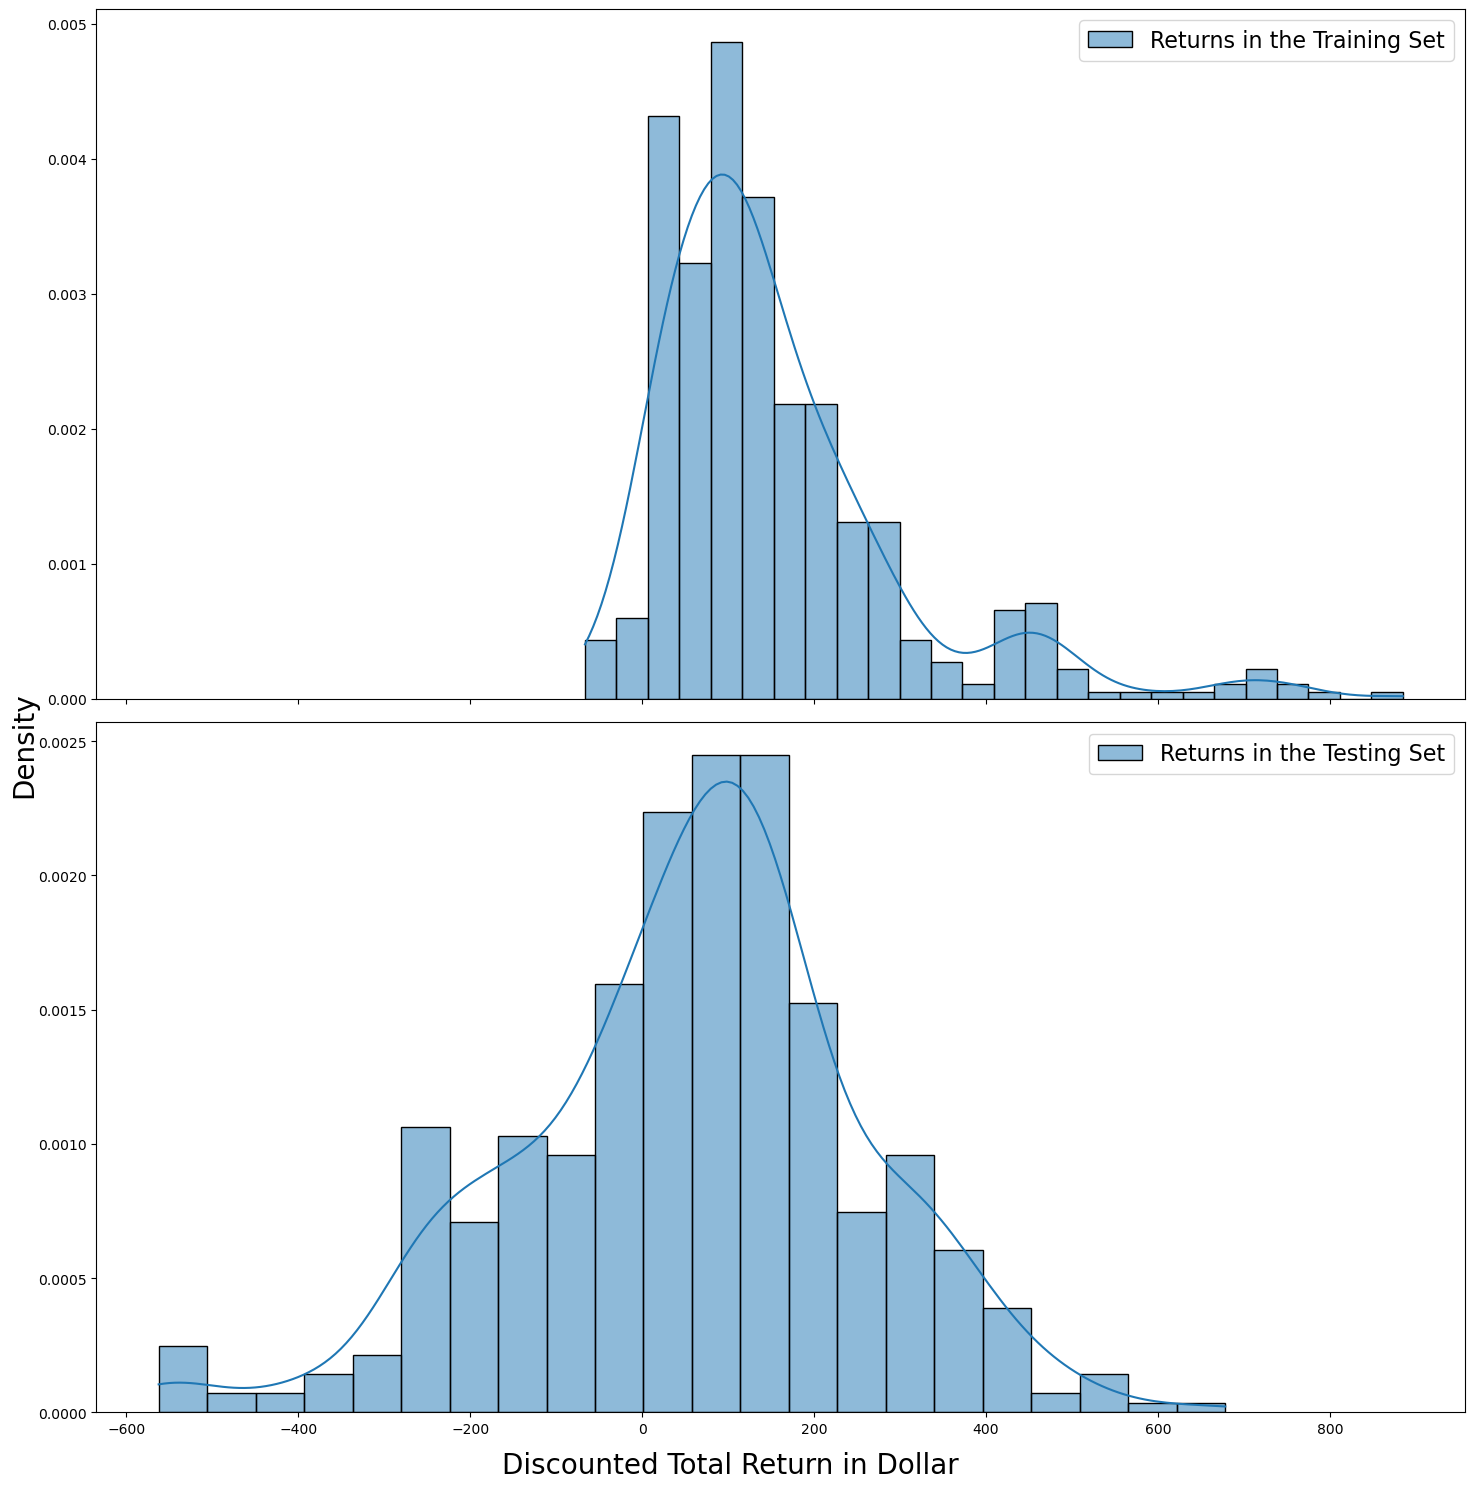

In [26]:
def adjacent_plots(input_lists):
    '''
    Create subplots that share a common x-axis
    Subplots include the unconditional return plot and other conditional
    on key words plots
    '''
    fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15, 15))
    sns.histplot(input_lists[0], stat="density", label=f"Returns in the Training Set",
                 kde=True, fill=True, ax=axs[0]).set(xlabel=None, ylabel=None)
    sns.histplot(input_lists[1], stat="density", label=f'Returns in the Testing Set',
                 kde=True, fill=True, ax=axs[1]).set(xlabel=None, ylabel=None)
    #axs[0].set_xlim(0,5)
    axs[0].legend(loc="upper right", prop={"size": 16})
    axs[1].legend(loc="upper right", prop={"size": 16})
    fig.supxlabel("Discounted Total Return in Dollar", fontsize=20)
    fig.supylabel("Density", fontsize=20)
    plt.tight_layout()
    plt.show()
adjacent_plots([train_returns, test_returns])